# Station Air Pollution Estimation

For each station, find a good model to predict the individual pollutants.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns


from utils import *

datasets_folder = './datasets'
verbosity=0

## Data Import

We will only focus on the station with the most agents, Porta San Felice.

In [2]:
san_felice_pollution_dict = read_and_preprocess_dataset(datasets_folder, 'pollution', resample=False, v=verbosity)[1]
san_felice_traffic_df = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity)[1]
weather_df = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

In [3]:
san_felice_data = prepare_station_data_for_training(san_felice_pollution_dict, san_felice_traffic_df, weather_df)
print(*list(san_felice_data.keys()), sep=', ')
list(san_felice_data.values())[0].head(5)

C6H6, CO, NO, NO2, NOX, PM10, PM2.5


,Date,Agent_value,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,W_VEC_INT,LEAFW,ET0,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2019-01-01 02:00:00,4.6,0.077825,0.087470,0.0,0.905034,0.0,0.075342,0.439167,0.068966,0.0,0.0,0.500000,8.660254e-01,0.201299,0.97953,0.5,0.866025
1,2019-01-01 03:00:00,4.7,0.050691,0.080378,0.0,0.902746,0.0,0.047945,0.526111,0.027586,0.0,0.0,0.707107,7.071068e-01,0.201299,0.97953,0.5,0.866025
2,2019-01-01 04:00:00,4.6,0.032953,0.094563,0.0,0.843249,0.0,0.047945,0.480278,0.041379,0.0,0.0,0.866025,5.000000e-01,0.201299,0.97953,0.5,0.866025
3,2019-01-01 05:00:00,4.5,0.024629,0.125296,0.0,0.767735,0.0,0.123288,0.419444,0.103448,0.0,0.0,0.965926,2.588190e-01,0.201299,0.97953,0.5,0.866025
4,2019-01-01 06:00:00,4.2,0.020357,0.066194,0.0,0.831808,0.0,0.123288,0.940833,0.117241,0.0,0.0,1.000000,6.123234e-17,0.201299,0.97953,0.5,0.866025


## Models

For each station we develop a model to describe the air pollution. Given that each station collects different data, and sometimes with different intensities, we decided to treat each station indepentendtely.

Air polution follows this criteria:
- for each pollutant a certain limit is defined (like 25 µg/m³ for PM2.5)
- for each pollutant $ AQI = \frac{Concentration}{Limit} \times 100 $
- take the maximum value across all the IQAs 

The overage value is then matched on the following table:

| **AQI**         | **CONDITIONS** |
| --------------- | -------------- |
| <30             | EXCELLENT      |
| From 34 to 66   | GOOD           |
| From 67 to 99   | FAIR           |
| From 99 to 150  | POOR           |
| >150            | VERY POOR      |

We are going to model each agent to predict its hour value and then use all of the predictions to compute the overall Air Quality Index and compare it with the one got from the readings.

In [4]:
pollutant_limits = {
    'PM2.5': 25,    # µg/m³
    'PM10': 50,     # µg/m³
    'CO': 10,       # mg/m³
    'O3': 180,      # µg/m³
    'NO': None,     # µg/m³
    'NO2': 200,     # µg/m³
    'NOX': None,    # µg/m³
    'C6H6': None    # µg/m³
}

In [5]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

From the first notebook:
- Agent C6H6: 3675 *(0.0699%)* missing Values
- Agent CO: 821 *(0.0156%)* missing Values
- Agent NO: 1056 *(0.0201%)* missing Values
- Agent NO2: 1056 *(0.0201%)* missing Values
- Agent NOX: 940 *(0.0179%)* missing Values
- Agent PM10: 57 *(0.0260%)* missing Values
- Agent PM2.5: 54 *(0.0246%)* missing Values

We focus on CO beacuse it has the least missing values.

### **CO estimations**

In [6]:
co_x_train, co_y_train, co_x_test, co_y_test = create_train_test(san_felice_data['CO'], train_split_date, y=target)

#### **Random Forest Classifier**

eh i dati devono essere interi perchè lui prova ad assegnare una classe piuttosto che un valore... si può ovviamente risolvere moltiplicando per qualche potenza di 10 ma non è proprio corretto...

In [ ]:
from sklearn.ensemble import RandomForestClassifier

co_rand_forest = RandomForestClassifier(random_state=42)

co_rand_forest.fit(co_x_train,co_y_train[target])

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
co_y_pred = co_rand_forest.predict(co_x_test)

In [ ]:
co_y_pred_df = pd.DataFrame(co_y_pred, index=co_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

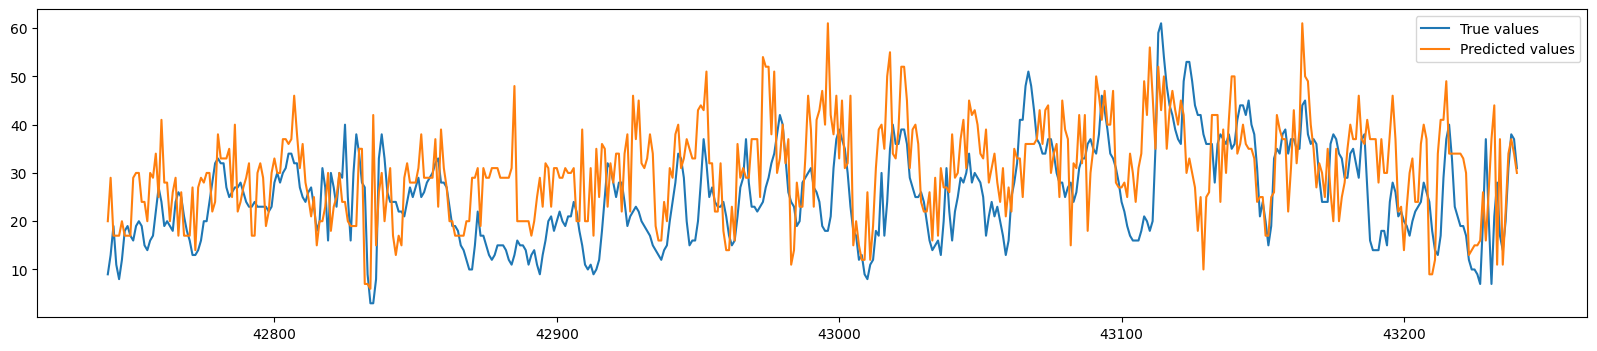

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[:500], label='True values')
plt.plot(co_y_pred_df.iloc[:500], label='Predicted values')
plt.legend()
plt.show()

#### **Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

co_rand_forest = RandomForestRegressor(random_state=42)

co_rand_forest.fit(co_x_train,co_y_train[target])

RandomForestRegressor(random_state=42)

In [ ]:
co_y_pred = co_rand_forest.predict(co_x_test)

In [ ]:
co_y_pred_df = pd.DataFrame(co_y_pred, index=co_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

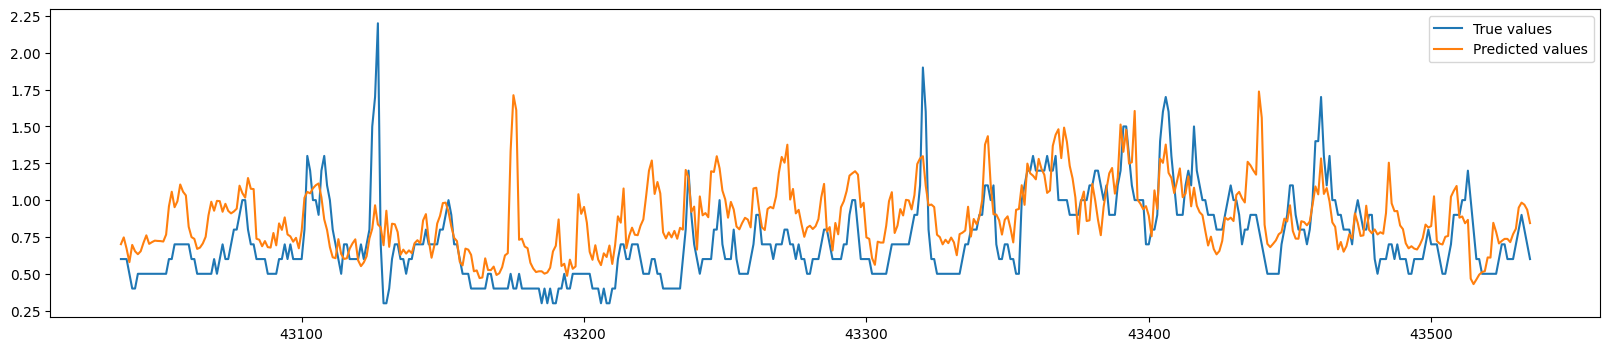

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[:500], label='True values')
plt.plot(co_y_pred_df.iloc[:500], label='Predicted values')
plt.legend()
plt.show()

#### **LSTM**

##### tsflow

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

ImportError: Traceback (most recent call last):
  File "C:\Users\Davide\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: Routine di inizializzazione della libreria di collegamento dinamico (DLL) non riuscita.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
def build_model(in_shape,
                optimizer='adam',
                loss='mse'
                ):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(in_shape[1], in_shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

In [ ]:
def create_sequences(x_df, y_df, time_steps=10):
    X, y = [], []
    for i in range(len(x_df) - time_steps):
        X.append(x_df.iloc[i:i+time_steps].values)
        y.append(y_df.iloc[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 5  # Use past 30 hours for prediction
feature_cols = co_x_train.columns.tolist()

co_x_train_seq, co_y_train_seq = create_sequences(co_x_train, co_y_train, time_steps)
co_x_test_seq, co_y_test_seq = create_sequences(co_x_test, co_y_test, time_steps)

In [ ]:
co_lstm = build_model(co_x_train_seq.shape)
co_lstm.fit(co_x_train_seq, co_y_train_seq, epochs=10, batch_size=16, verbose=1)

InvalidArgumentError: Multiple OpKernel registrations match NodeDef at the same priority '{{node AssignVariableOp}}': 'op: "AssignVariableOp" device_type: "GPU" constraint { name: "dtype" allowed_values { list { type: DT_INT64 } } } host_memory_arg: "resource"' and 'op: "AssignVariableOp" device_type: "GPU" constraint { name: "dtype" allowed_values { list { type: DT_INT64 } } } host_memory_arg: "resource"'
	 [[AssignVariableOp]] [Op:AssignVariableOp]

##### pytorch

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Forward pass through LSTM
        lstm_out, (hn, cn) = self.lstm(x)
        
        # Get the output from the last time step (last row of LSTM output)
        out = self.fc(lstm_out[:, -1, :])  # We take the last timestep output
        return out

# Example usage
input_size = 10  # Number of input features
hidden_size = 50  # Size of the LSTM hidden layer
output_size = 1  # Number of output units (e.g., predicting a single value like pollution level)
num_layers = 2  # Number of LSTM layers
dropout = 0.2  # Dropout rate

# Instantiate the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example dummy data
X_train = torch.randn(32, 10, input_size)  # (batch_size, seq_length, input_size)
y_train = torch.randn(32, output_size)  # (batch_size, output_size)

# Forward pass (training example)
model.train()
optimizer.zero_grad()  # Zero the gradients
output = model(X_train)  # Forward pass through the model
loss = criterion(output, y_train)  # Compute the loss
loss.backward()  # Backpropagate the loss
optimizer.step()  # Update the weights

print(f"Training loss: {loss.item()}")


In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients from previous step
    output = model(X_train)  # Forward pass
    loss = criterion(output, y_train)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


In [ ]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # No need to compute gradients during inference
    test_output = model(X_test)
    print(f"Test predictions: {test_output}")


#### Feed Forward Neural Network

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [44]:
def build_ffnn(in_shape, optimizer='adam', loss='mse'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(in_shape,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

in_shape = len(co_x_train.columns)
co_ffnn = build_ffnn(in_shape)
print(co_ffnn.summary()) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              17408     
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 608,001
Trainable params: 608,001
Non-tr

In [45]:
co_ffnn.fit(co_x_train, co_y_train, epochs=10, batch_size=32)

Epoch 1/10
1345/1345 [==============================] - 7s 5ms/step - loss: 0.0504
Epoch 2/10
1345/1345 [==============================] - 6s 4ms/step - loss: 0.0454
Epoch 3/10
1345/1345 [==============================] - 6s 4ms/step - loss: 0.0442
Epoch 4/10
1345/1345 [==============================] - 6s 4ms/step - loss: 0.0432
Epoch 5/10
1345/1345 [==============================] - 7s 5ms/step - loss: 0.0420
Epoch 6/10
1345/1345 [==============================] - 6s 4ms/step - loss: 0.0412
Epoch 7/10
1345/1345 [==============================] - 6s 4ms/step - loss: 0.0403
Epoch 8/10
1345/1345 [==============================] - 6s 4ms/step - loss: 0.0398
Epoch 9/10
1345/1345 [==============================] - 6s 4ms/step - loss: 0.0388
Epoch 10/10
1345/1345 [==============================] - 6s 5ms/step - loss: 0.0387


In [46]:
co_y_pred = co_ffnn.predict(co_x_test)
co_y_pred_df = pd.DataFrame(co_y_pred, index=co_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

273/273 [==============================] - 0s 1ms/step


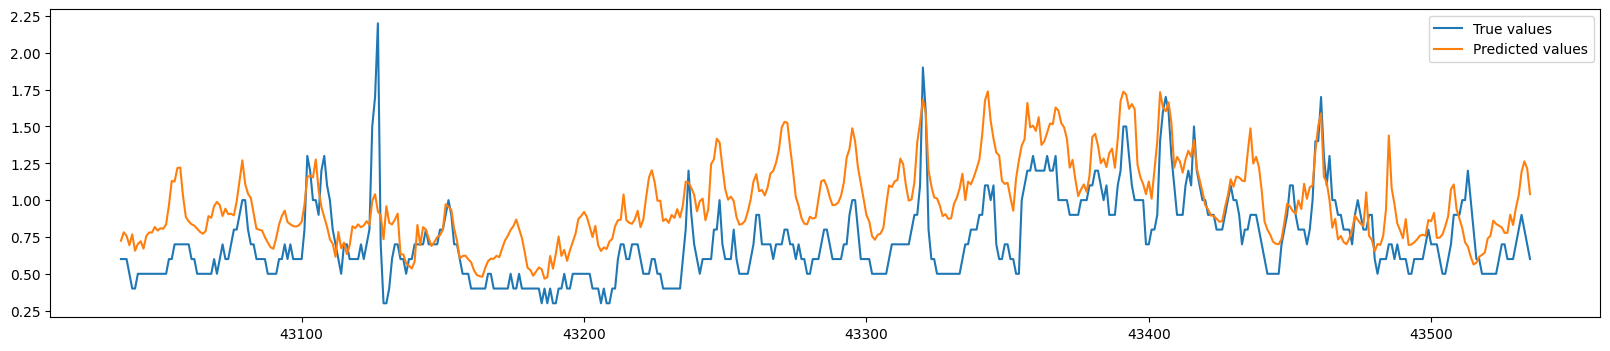

In [47]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[:500], label='True values')
plt.plot(co_y_pred_df.iloc[:500], label='Predicted values')
plt.legend()
plt.show()